In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

 ## Researching survivors of the titanic

 ### Sources:
- [Sinking of the titanic](https://en.wikipedia.org/wiki/Sinking_of_the_Titanic)
- [Titanic](https://en.wikipedia.org/wiki/Titanic)

 ### Key points:

- The accident happened at midnight when many passengers were in their cabins asleep.
- Flooding started in the lower decks first towards the bow.
- There was capacity for ~50% of total crew and passengers on the lifeboats which were all on the boat deck at the very top of the ship.
- The passenger cabins were arranged generally by class with the majority of First Class passengers all being in cabins higher up the ship, with second class generally on the same or lower decks as first with third class cabins being lower still.
- First and second class passengers had direct access to this deck but third class passengers did not due to US law at the time requiring third class passenger to be segregrated for disease control.  When the order was given to muster on the boat deck crew were sent to open doors to enable access - but there are reports that this may not have happened consistently.
- "Women and children first".  This was the maritime rule common at the time.  It's intepretation was inconsistent - with reports that the port side boarding applied a "women and children only" policy initially, while on the starboard side a looser policy of mainly women and children but some men if there was space was applied from the beginning.
- The stewards onboard were tasked with getting the passengers to the boat deck - but there were far fewer stewards per passenger in third class.
- The situation was chaotic and confusing.  The limited instructions from stewards / crew were all in English.  Reports than many non english speakers in third class were confused and had no idea what to do.
- Social indoctrination and fear of stigma may have played a part in male survival rates.  Reports of first class male passengers refusing to board lifeboards for fear of being seen as cowards, while some lower class expected to be ordered what to do and were passive in taken life saving actions.
- From account of third party passengers who survived, some were alerted / helped by other people in their party.  There are also stories of whole groups (like the Sage Family) not surviving as they did not want to split up their group and turned down places in the boats.  So +/- effects.

### Key features expected to impact on survival:
 - *Sex* - Being female
 - *Age* - primarily being a child, but other age groups could also have different survival chances
 - *Class* - proximity to the boat deck and access to stewards both correlate to passenger class.
 - *Group size* - Being accompanied / being in a group.
 - *Social* - Being able to understand instructions - 'english speaking', willingness to go against social conventions

In [122]:
# Read the data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [123]:
# Examine the data structure
train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,1
1,2,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,1
2,3,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,0
3,5,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,0
4,6,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,1


In [124]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Review of data

We now want to take each of key features we identified in our research as see what data we have  in our training dataset that would map to that feature.

As we go through the data there will be information that we will want to use in preprocessing the test set.  We will store this data in a preprocessing dict.

In [125]:
pre_data = {
    'train': train.copy(),
    'test': test.copy(),
    'drop_list': ['PassengerId'],
    'one_hot_cols': []}

### Sex

In [126]:
def encode_sex(df):
    df["Sex"] = (df['Sex'] == 'female').astype(int)
    return df

train = encode_sex(train)

### Age
Age is more difficult as we have a lot of missing data.  We can try and guess age based on a couple of other data-points:
 - The persons title. e.g. Master is a title used predominately for young men.
 - Whether accompanied by a parent may be useful to discern children.  We don't have this specific info but we have "Parch".  This could be useful, particularly for the "Miss" title as at the time it would be less likely that a "Miss" had children and therefore having a +ve value of "Parch" could mean that they were more likely to be a child.

In [127]:
def add_title_feature(df):
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    is_other = lambda x: "Other" if x not in ['Mr', 'Miss', 'Mrs', 'Master'] else x
    df['Title'] = df['Title'].apply(is_other)
    return df


def add_has_parent_feature(df):
    df['Has_Parent'] = df['Parch'] > 0
    return df

train = add_title_feature(train)
train = add_has_parent_feature(train)


# Create median ages for each title by 'Has_parent' to fill in missing ages
age_medians = (train.groupby(['Title', 'Has_Parent'])['Age']
               .agg(['median', 'min', 'max', 'count']))

pre_data['age_medians'] = age_medians
age_medians

median      min   max  count
Title  Has_Parent                              
Master False         12.0  12.0000  12.0      1
       True           3.0   0.4167  11.0     35
Miss   False         26.0   5.0000  63.0     91
       True           9.0   0.7500  39.0     55
Mr     False         29.0  11.0000  80.0    350
       True          35.0  14.0000  65.0     48
Mrs    False         35.0  14.0000  63.0     55
       True          36.0  18.0000  58.0     53
Other  False         44.5  23.0000  60.0     24
       True          49.0  28.0000  70.0      2

This seems to indicate that "Title" combined with "Has_parent" is useful for guessing unknown ages - particularly as hoped for the "Miss" title.

In [128]:
# First lets fill in the missing ages using the median age for "Title" and "Has_Parent"

def fill_age(df, medians):
    def fill_age(row):
        if pd.isnull(row['Age']):
            return medians.loc[row['Title'], row['Has_Parent']]['median']
        else:
            return row['Age']
    df['Age'] = df.apply(fill_age, axis=1)
    return df


# Let fill in the missing ages
train = fill_age(train, age_medians)

# Let's  bin the ages
age_bins = [0, 2, 15, 30, 60, 100]
train['Age'] = pd.cut(train['Age'], bins=age_bins, labels=False)


# We're done with the Name and Title and Has_Parents columns, so lets drop them
pre_data['drop_list'].extend(['Name', 'Title', 'Has_Parent'])

#  Now lets look at the impact of age on survival
index = ['Age']
(train
    .groupby(index)['Survived']
    .agg(['mean', 'count'])
    .style.format({ 
        "mean": "{:.1%}".format,
        "count": "{:,}".format
        }))

,mean,count
Age,,
0,62.5%,24
1,51.4%,72
2,32.5%,468
3,43.6%,305
4,22.7%,22


The age types seem reasonable differentiated in terms of survival rate so we should include this in the model.

### Class

The Pclass data is already in the feature set.  For use in our model we want to ohe this data

### Group size

Now lets look at the size of group and how it impacts on survival. We have multiple data point that might help us hear:
- We have "Parch" + "SipSp" - these together are the size of family on board.
- We also have "Ticket".  We can see that many tickets were shared - so a "group" could be more broadly defined as being people traveling together on a shared ticket.

The issue with "Shared Tickets" is that if we only use the train data set then shared ticket counts will be understated. Further if we calculate in isolation then the test set (with its smaller size) will be more biased towards a lower group size than the training set.  There is no good way of correcting this bias without leaking information for the test set into the training set.  Using this feature therefore can be introducing some bad data into the model - however we can only explore the extent to which it helps or hurts by trying the model with and wihout this feature.

In [129]:
def generate_shared_tickets(df):
    shared = df.groupby('Ticket')['Ticket'].count()
    shared = shared[shared > 1]
    return shared

# We can create a table of shared tickets in the training set
training_shared = generate_shared_tickets(train)
test_shared = generate_shared_tickets(test)

# Function that we can use to ensure compromise between the train / test sets - if the ticket is shared in the training set, use that count
def get_group_size(df, train_shared, test_shared, is_train=True):
    def get_train_count(x):
        if x in train_shared.index:
            return train_shared[x]
        else:
            return 1
        
    def get_test_count(x):
        train_count = get_train_count(x)
        if train_count > 1:
            return train_count
        elif x in test_shared.index:
            return test_shared[x]
        else:
            return 1

    df['Family_size'] = df['SibSp'] + df['Parch'] + 1
    apply_func = get_train_count if is_train else get_test_count
    
    df['Group_size'] = df['Ticket'].apply(apply_func)
    df['Group_size'] = df[['Group_size','Family_size']].max(axis=1)
    df= df.drop('Family_size', axis=1)
    return df

train = get_group_size(train, training_shared, test_shared)
pre_data['train_shared_tickets'] = training_shared
pre_data['test_shared_tickets'] = test_shared

In [130]:
train['Group_size'].value_counts()

1     462
2     185
3     128
4      42
6      22
5      20
7      19
11      7
8       6
Name: Group_size, dtype: int64

In some ways the distribution fits with intuition - it might be expected that having support would increase chance of survival.  However that support seems to have limits - perhaps due to group dynamics of acting as whole.The distribution is also likely skewed by the outsized impact of the large groups i.e. the "Hong Kong" travelling group of 7 did relatively well, whereas the "Sage" group of 11 all died. 

In [131]:
# Bin Group size into 3 bins
group_size_bins = [0, 2, 4, 100]
train['Group_bins'] = pd.cut(
    train['Group_size'],
    bins=group_size_bins,
    labels=False)

# Now we can drop cols associated with Groups size
to_drop = ['Ticket', 'SibSp', 'Parch']
pre_data['drop_list'].extend(to_drop)

#  Now lets look at the impact of group size on survival
(train.groupby('Group_bins')['Survived']
    .agg(['mean', 'count'])
    .style.format({ "mean": "{:.2%}".format }))

,mean,count
Group_bins,,
0,33.54%,647
1,64.71%,170
2,20.27%,74


### Cabins
Ideally we would like to know Cabins for all passengers - as we would guess that that may well be correlated to survival given what we know of the disaster.  However the data for Cabins is very limited, our research revealing it came mainly from two sources:
- lists that the First Class stewards maintained
- accounts of survivors

As such give we already know that both First class passengers had ready access to the boat deck at had sufficent time to muster their cabins are largely irrelevant.  However it does help us indirectly for the small number of non first class passengers known - as it is correlated to survival.

In [132]:
def get_cabin_known(df):
    df['Cabin_known'] = (df['Cabin'].notnull() & (df['Pclass'] > 1)).astype(int)
    return df

train = get_cabin_known(train)

# Now lets look at the impact of cabin known on survival
train[train['Pclass'] > 1].groupby(['Pclass','Cabin_known'])['Survived'].mean()

Pclass  Cabin_known
2       0              0.440476
        1              0.812500
3       0              0.235908
        1              0.500000
Name: Survived, dtype: float64

Knowing the cabin has ~2x the likelihood of survival.

In [133]:
# Now we can drop the Cabin column
pre_data['drop_list'].append('Cabin')

### Fare
From background research it is difficult to see how 'Fare' would correlate outside of its shared information with Pclass and Group size, as from what we know of the disaster virtually all first and second class passengers could have gained access to the boat decks irrespective of the type of Cabin there were in and as such fare.  There is potentially information encoded in fare for First and Second which would mean they were more or less likely to have been muster on the 'port' or 'starboard' side - with the then different likihoods of men being allowed onto the boats.  There could also be information in Fare for Third Class passengers that would correlate as to which Deck they were on.  However in both cases I can't find any support for such a relationship in any research.

One observation from looking at the "Fare" is the number of zero fare passengers.

In [134]:
# Seem there is a group of 0 fares
train[train['Fare'] == 0]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title,Has_Parent,Group_size,Group_bins,Cabin_known
6,8,1,"Andrews, Mr. Thomas Jr",0,3,0,0,112050,0.0,A36,S,0,Mr,False,1,0,0
80,126,1,"Fry, Mr. Richard",0,2,0,0,112058,0.0,B102,S,0,Mr,False,1,0,0
99,151,1,"Harrison, Mr. William",0,3,0,0,112059,0.0,B94,S,0,Mr,False,1,0,0
147,224,1,"Parr, Mr. William Henry Marsh",0,2,0,0,112052,0.0,NaN,S,0,Mr,False,1,0,0
157,235,1,"Reuchlin, Jonkheer. John George",0,3,0,0,19972,0.0,NaN,S,0,Other,False,1,0,0
242,364,2,"Campbell, Mr. William",0,2,0,0,239853,0.0,NaN,S,0,Mr,False,3,1,0
255,385,2,"Cunningham, Mr. Alfred Fleming",0,2,0,0,239853,0.0,NaN,S,0,Mr,False,3,1,0
269,411,2,"Frost, Mr. Anthony Wood 'Archie'",0,2,0,0,239854,0.0,NaN,S,0,Mr,False,1,0,0
315,474,2,"Knight, Mr. Robert J",0,2,0,0,239855,0.0,NaN,S,0,Mr,False,1,0,0
353,529,2,"Parkes, Mr. Francis 'Frank'",0,2,0,0,239853,0.0,NaN,S,0,Mr,False,3,1,0


Some googling shows that these people (bar 1) were all travelling at the direction of the Line operator and are more akin to crew and were all male and almost all did not survive.  Seems a relevant feature.

In [135]:
# Lets create a feature for these people

def get_crew(df):
    df['Crew'] = (df['Fare'] == 0).astype(int)
    return df

train = get_crew(train)

# Now we can drop the Fare column
pre_data['drop_list'].append('Fare')

### Embarkation
For third class passengers there is a clear difference in survival between the cross of sex and port of embarkation - for first and second class passengers there is no clear difference.  
These differences could be related to a combination of english speaking and societal values of the time - (the last two items in the research list)


In [136]:
def fill_embarked(df):
    df['Embarked'] = df['Embarked'].fillna('S')
    return df

train = fill_embarked(train)

# Show table of Embarked and survival
(train.groupby(['Pclass', 'Sex', 'Embarked'])['Survived']
    .agg(['mean', 'count'])
    .style.format({ "mean": "{:.2%}".format }))


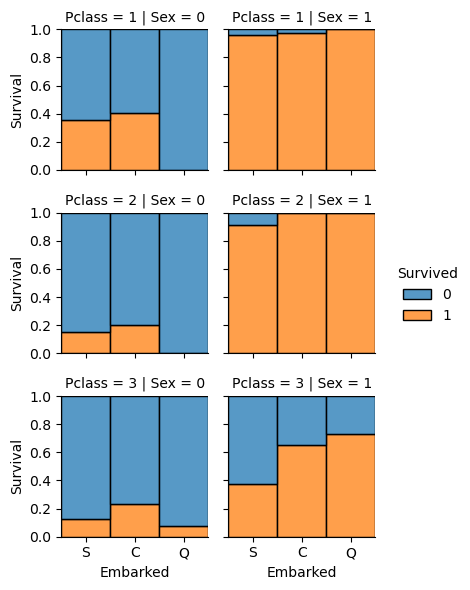

In [137]:

# Now lets look at the impact of Embarked on survival in a sns displot
em_plot = sns.displot(
    data=train,
    x='Embarked',
    row='Pclass',
    col='Sex',
    hue='Survived',
    kind='hist', 
    multiple='fill',
    fill=True,
    height=2,
).set_axis_labels('Embarked', 'Survival')

# Show pivot 


Concern of including is that Embarked clearly share a lot of info with Class as significantly more likely to be third class if embarked in "Q".  In third class - there is some clear difference between embark point and survival, but the trends are very different between the sexes.  For example "Q" females ("Irish") in 3rd were nearly twice as likely to survive as as those boarding in Southhampton, whereas "Q" males were almost twice as likely to have died as those from "S" - with "C" males faring almost twice as well again.  Is this a real trend or an artifact of the training data? The numbers are realativley small... 

In [138]:
# Lets fill the missing Embarked values with the most common value and cast to an ordinal feature
def encode_embarked(df):
    df['Embarked'] = df['Embarked'].fillna('S')
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    return df

train = encode_embarked(train)

In [139]:
train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title,Has_Parent,Group_size,Group_bins,Cabin_known,Crew
0,1,1,"Allen, Miss. Elisabeth Walton",1,2,0,0,24160,211.3375,B5,0,1,Miss,False,3,1,0,0
1,2,1,"Allison, Master. Hudson Trevor",0,0,1,2,113781,151.5500,C22 C26,0,1,Master,True,4,1,0,0
2,3,1,"Allison, Miss. Helen Loraine",1,0,1,2,113781,151.5500,C22 C26,0,0,Miss,True,4,1,0,0
3,5,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,2,1,2,113781,151.5500,C22 C26,0,0,Mrs,True,4,1,0,0
4,6,1,"Anderson, Mr. Harry",0,3,0,0,19952,26.5500,E12,0,1,Mr,False,1,0,0,0


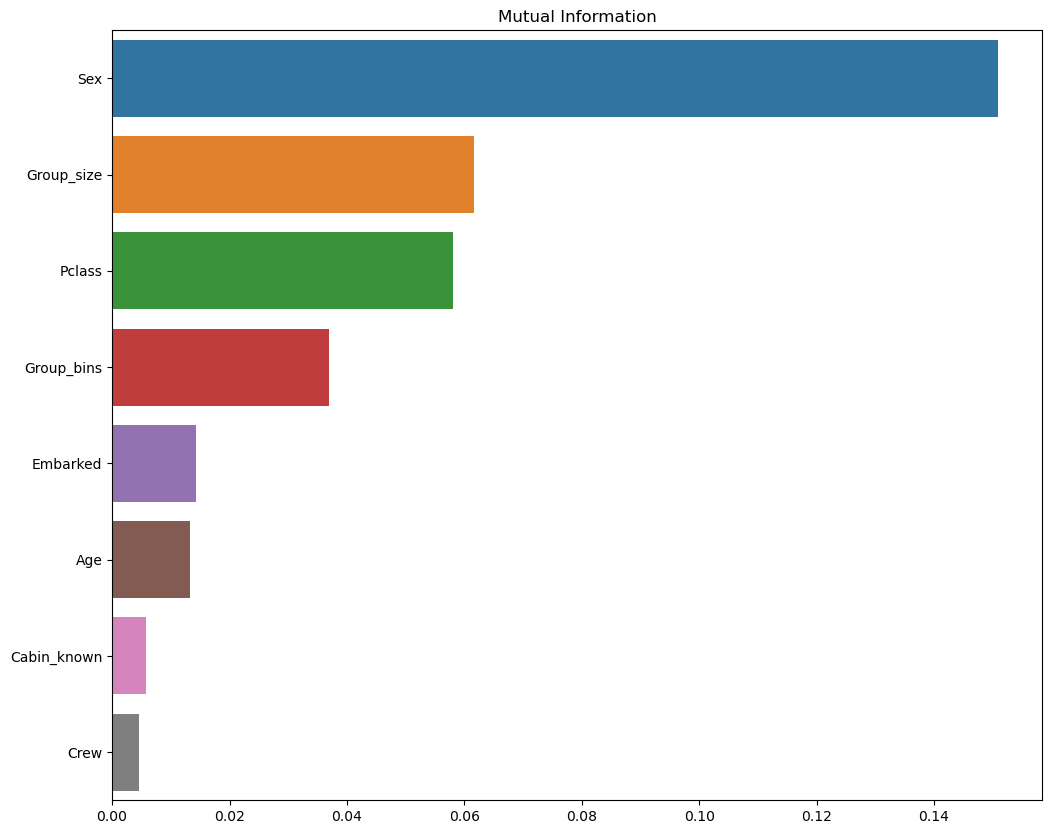

In [140]:
from sklearn.feature_selection import mutual_info_classif


def pop_survived(df):
    survived = df['Survived']
    df = df.drop('Survived', axis=1)
    return df, survived

train_copy = train.copy()
train_copy = train_copy.drop(pre_data['drop_list'], axis=1)

X_train, y_train = pop_survived(train_copy)

# Lets ensure that all the features we selected have information content
mutual_info = pd.Series(
    mutual_info_classif(X_train, y_train, discrete_features=True), # type: ignore
    index=X_train.columns
    ).sort_values(ascending=False)

# Plot the mutual information
plt.figure(figsize=(12, 10))
sns.barplot(x=mutual_info, y=mutual_info.index, log=False)
plt.title('Mutual Information')
plt.show()

Looks like all the features we created for training have information content for 'Survival'.  Now we carry out the same pre-processing procedures again on a clean set, this time one-hot encoding our ordinal features. We will do this for both the test and train sets.

In [141]:
def preprocess(pre_data, is_train=True):
    df = pre_data['train'] if is_train else pre_data['test']
    df = encode_sex(df)
    df = add_title_feature(df)
    df = add_has_parent_feature(df)
    df = fill_age(df,medians=pre_data['age_medians'])
    df['is_Child'] = (df['Age'] < 14).astype(int)

    df = get_group_size(
        df,
        train_shared = pre_data['train_shared_tickets'],
        test_shared=pre_data['test_shared_tickets'],
        is_train=is_train)
    
    df['Small_group'] = (df['Group_size'] < 3).astype(int)
    
    df['Group_size'] = pd.cut(df['Group_size'], bins=[0, 2, 4, 100], labels=False)
    df = get_cabin_known(df)
    df = get_crew(df)
    df = encode_embarked(df)
    df = df.drop([*pre_data['drop_list'], 'Age', 'Group_size'], axis=1)
    df['Pclass'] = df['Pclass'].astype(int) - 1
    x, y = pop_survived(df)
    return x, y

def get_model_data(pre_data):
    test_passenger_ids = pre_data['test']['PassengerId']
    X_train, y_train = preprocess(pre_data)
    X_test, y_test = preprocess(pre_data, is_train=False)
    return {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'test_passenger_ids': test_passenger_ids}

In [142]:
data = get_model_data(pre_data)

In [143]:
data['X_train'].describe()

,Pclass,Sex,Embarked,is_Child,Small_group,Cabin_known,Crew
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,1.308642,0.352413,0.361392,0.094276,0.726150,0.031425,0.016835
std,0.836071,0.477990,0.635673,0.292377,0.446183,0.174562,0.128725
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [144]:
data['X_test'].describe()

,Pclass,Sex,Embarked,is_Child,Small_group,Cabin_known,Crew
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1.265550,0.363636,0.464115,0.078947,0.746411,0.026316,0.004785
std,0.841838,0.481622,0.685516,0.269980,0.435586,0.160265,0.069088
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [145]:
from sklearn.model_selection import GridSearchCV

def get_best_model(model, param_grid, data, name=None):
    # Instantiate the grid search model
    grid = GridSearchCV(
        estimator = model,
        param_grid = param_grid,     
        cv = 5,
        refit=True,
        scoring='accuracy',
        n_jobs = -1,
        verbose = 0)

    # Fit the grid search to the data - as refit=True, this will automatically refit the best model and enable predict on best model
    grid.fit(data['X_train'], data['y_train'])
    best_model = grid.best_estimator_

    if not name:
        name = model.__class__.__name__

    print(f"Best {name} model:")
    print("-"*79)
    print(f"\tBest Classifier hyperparameters: {grid.best_params_}")
    print(f"\tBest Validation score: {grid.best_score_: .2%}")
    print(f"\tTest Accuracy: {grid.score(data['X_test'], data['y_test']):.2%}")
    print("")

    return best_model

In [146]:
no_dummies_params = {
    "rf": {  
        'criterion' : ['gini', 'entropy'],
        'max_depth' : [ 5,6,7, ],
        'n_estimators': [115, 120, 125],},
    "xgb": {
        'learning_rate': [ 0.39, 0.4, 0.41, ],
        'max_depth': [ 2, 3, 4,],
        'n_estimators': [ 49, 50, 51,]
        },
    "svc": {
        'C': [  26, 27, 28 ],
        'kernel': ['poly'], #['poly', 'rbf', 'sigmoid', 'linear',],
        }
}

In [147]:
from sklearn.ensemble import RandomForestClassifier

# Explore to find the best hyperparameters for a random forest model
param_grid = {  
    'criterion' : ['gini', 'entropy'],
    'max_depth' :   [ 5, 6, 7, 8, ],
    'n_estimators': [ 80, 85,],
}

model = RandomForestClassifier(random_state=1)
rf = get_best_model(model, param_grid, data)

Best RandomForestClassifier model:
-------------------------------------------------------------------------------
	Best Classifier hyperparameters: {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 80}
	Best Validation score:  75.11%
	Test Accuracy: 79.43%



In [148]:
from xgboost import XGBClassifier

# Explore to find the best hyperparameters for an XGBoost model
param_grid = {
    'learning_rate': [ 0.35, 0.38, 0.39, 0.4, 0.41, 0.42, 0.5 ],
    'max_depth': [ 2, 3,4,5,],
    'n_estimators': [ 80, 100, 200  ]
}

xgb = get_best_model(XGBClassifier(random_state=1), param_grid, data)

Best XGBClassifier model:
-------------------------------------------------------------------------------
	Best Classifier hyperparameters: {'learning_rate': 0.35, 'max_depth': 2, 'n_estimators': 200}
	Best Validation score:  75.33%
	Test Accuracy: 78.23%



In [149]:
from sklearn.svm import SVC

# Create param grid for GridSearchCV using an SVC classifier
param_grid = {
    'C': [ 0.63, 0.64, 0.65, 10, 11, 26, 27, 28 ],
    'kernel': ['poly'], #['poly', 'rbf', 'sigmoid', 'linear',],
} 

# Create the SVC classifier - note that we are using the probability=True parameter so we can use predict_proba in VotingClassifier
svc = get_best_model(SVC(random_state=1, probability=True), param_grid, data)

Best SVC model:
-------------------------------------------------------------------------------
	Best Classifier hyperparameters: {'C': 10, 'kernel': 'poly'}
	Best Validation score:  75.22%
	Test Accuracy: 78.95%



In [150]:
from sklearn.ensemble import VotingClassifier

# Create a list of (string, estimator) tuples
estimators = [("rf", rf), ("xgb", xgb), ( "svc", svc)]

# Create a voting classifier - using soft / hard voting 
soft = VotingClassifier(estimators, voting='soft', n_jobs=-1)
soft.fit(data['X_train'], data['y_train'])
print(f"Accuracy soft: {soft.score(data['X_test'], data['y_test']): .1%}")

hard = VotingClassifier(estimators, voting='hard', n_jobs=-1)
hard.fit(data['X_train'], data['y_train'])
print(f"Accuracy hard: {hard.score(data['X_test'], data['y_test']): .1%}")

Accuracy soft:  79.4%
Accuracy hard:  79.4%
